<a href="https://colab.research.google.com/github/imranrahman1997/TensorFlow-Course/blob/master/plant_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"eigahiga","key":"ab768d3d43c34efc00584e49dd18ecfc"}'}

In [3]:

#before importing the dataset we want to use this code
# The Kaggle API client expects this file to be in ~/.kaggle,
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d noulam/tomato

 99% 737M/743M [00:10<00:00, 115MB/s]
100% 743M/743M [00:10<00:00, 75.5MB/s]


In [5]:
from zipfile import ZipFile

file_name = "/content/tomato.zip"

with ZipFile(file_name, "r") as zip:
  zip.extractall()
  print("done")

done


In [6]:
!pip install tensorflow-gpu

     |████████████████████████████████| 320.4MB 52kB/s 


In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [7]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [8]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob

In [9]:
IMAGE_SIZE = [224, 224]

train_path = "/content/Datasets/train"
test_path = "/content/Datasets/test"

In [10]:
inception = InceptionV3(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top= False)

87916544/87910968 [==============================] - 0s 0us/step


In [11]:
for layer in inception.layers:
  layer.trainable = False

In [12]:
#NUMBER of out put classes
folders = glob("/content/Datasets/train/*")

In [13]:
#our flatten layer
x = Flatten()(inception.output)

In [14]:
import tensorflow as tf
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>0.97):
        print("\nReached 60% accuracy so cancelling training!")
        self.model.stop_training = True

callbacks = myCallback()

In [15]:
prediction = Dense(len(folders), activation = 'softmax')(x)

#creat model object
model = Model(inputs = inception.input , outputs = prediction)

In [16]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [17]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [18]:
#use image generator
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range  = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [19]:
training_set = train_datagen.flow_from_directory('/content/Datasets/train',
                                                 target_size = (224, 224),
                                                 batch_size = 18,
                                                 class_mode = 'categorical')

Found 18345 images belonging to 10 classes.


In [20]:
test_set = test_datagen.flow_from_directory("/content/Datasets/test",
                                           target_size  = (224, 224),
                                           batch_size = 18,
                                           class_mode = "categorical")

Found 4585 images belonging to 10 classes.


In [21]:
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=70,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set),
  callbacks=[callbacks]
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/70
1020/1020 [==============================] - 250s 245ms/step - loss: 3.8253 - accuracy: 0.6821 - val_loss: 2.5421 - val_accuracy: 0.7902
Epoch 2/70
1020/1020 [==============================] - 248s 243ms/step - loss: 3.2439 - accuracy: 0.7835 - val_loss: 2.6726 - val_accuracy: 0.8094
Epoch 3/70
1020/1020 [==============================] - 248s 243ms/step - loss: 3.1224 - accuracy: 0.8186 - val_loss: 3.1937 - val_accuracy: 0.8087
Epoch 4/70
1020/1020 [==============================] - 248s 243ms/step - loss: 2.9593 - accuracy: 0.8355 - val_loss: 3.5612 - val_accuracy: 0.8233
Epoch 5/70
1020/1020 [==============================] - 248s 243ms/step - loss: 2.9060 - accuracy: 0.8494 - val_loss: 4.4640 - val_accuracy: 0.8044
Epoch 6/70
1020/1020 [==============================] - 247s 242ms/step - loss: 2.7657 - accuracy: 0.8609 - val_loss: 3.8659 - val_accuracy: 0.8336
Epoch 7/70
1020/1020 [==============

In [22]:
import matplotlib.pyplot as plt

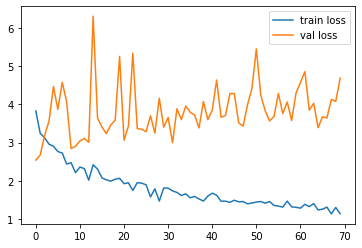

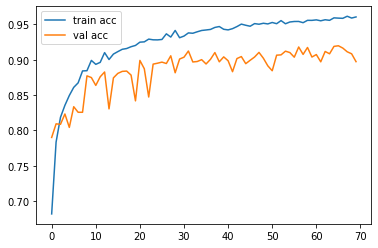

<Figure size 432x288 with 0 Axes>

In [23]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [24]:
from tensorflow.keras.models import load_model
model.save("model_inception.h5")

In [25]:
y_pred = model.predict(test_set)

In [26]:

y_pred

array([[0.0000000e+00, 9.2329460e-01, 7.6705411e-02, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00],
       [1.3986229e-21, 1.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [27]:
import numpy as np
y_pred = np.argmax(y_pred, axis = 1)

In [28]:
y_pred

array([1, 4, 9, ..., 8, 9, 1])

In [50]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(224, 224,3))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images)
  

  print(classes)
  
classes2 = np.argmax(classes, axis=1)

if classes2[0] == 0:
        print('it is Tomato_Yellow_Leaf_Curl_Virus')
elif classes2[0] == 1:
        print('It is Tomato_mosaic_virus')
elif classes2[0] == 2:
        print('It is a Septoria_leaf_spot')
elif classes2[0] == 3:
        print('It is a Spider_mites')
elif classes2[0] == 4:
        print('It is a Late_blight')
elif classes2[0] == 5:
        print('It is a healthy')
elif classes2[0] == 6:
        print('It is a Early_blight')
elif classes2[0] == 7:
        print('It is a Bacterial_spot')    
elif classes2[0] == 8:
        print('It is a Leaf_Mold')
elif classes2[0] == 9:
        print('It is a Target_Spot')    
else:
        print('Can\'t recognize the image')

print('done')

Saving 000bf685-b305-408b-91f4-37030f8e62db___GH_HL Leaf 308.1.JPG to 000bf685-b305-408b-91f4-37030f8e62db___GH_HL Leaf 308.1.JPG
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
It is a Target_Spot
done


In [47]:
folders

['/content/Datasets/train/Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 '/content/Datasets/train/Tomato___Tomato_mosaic_virus',
 '/content/Datasets/train/Tomato___Septoria_leaf_spot',
 '/content/Datasets/train/Tomato___Spider_mites Two-spotted_spider_mite',
 '/content/Datasets/train/Tomato___Late_blight',
 '/content/Datasets/train/Tomato___healthy',
 '/content/Datasets/train/Tomato___Early_blight',
 '/content/Datasets/train/Tomato___Bacterial_spot',
 '/content/Datasets/train/Tomato___Leaf_Mold',
 '/content/Datasets/train/Tomato___Target_Spot']

In [51]:
test_set

In [54]:
class_dict = training_set.class_indices
class_dict

{'Tomato___Bacterial_spot': 0,
 'Tomato___Early_blight': 1,
 'Tomato___Late_blight': 2,
 'Tomato___Leaf_Mold': 3,
 'Tomato___Septoria_leaf_spot': 4,
 'Tomato___Spider_mites Two-spotted_spider_mite': 5,
 'Tomato___Target_Spot': 6,
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 7,
 'Tomato___Tomato_mosaic_virus': 8,
 'Tomato___healthy': 9}

In [64]:
import numpy as np
from google.colab import files
from keras.preprocessing import image


uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path =  fn
  img = image.load_img(path, target_size=(224, 224,3))
  x = image.img_to_array(img)
  x = x / 255
  x = x.reshape(-1, 224, 224, 3)
  images = np.vstack([x])
  prediction = model.predict(images)
  

  print(prediction)
  


if np.argmax(prediction) == 0:
    print("Tomato___Bacterial_spot")
elif np.argmax(prediction) == 1:
    print("Tomato___Early_Blight")
elif np.argmax(prediction) == 2:
    print("Tomato___Late Blight")
elif np.argmax(prediction) == 3:
    print("Tomato___Leaf Mold")
elif np.argmax(prediction) == 4:
    print("Tomato___Septoria Leaf Spot")
elif np.argmax(prediction) == 5:
    print("Tomato___Spider mites")
elif np.argmax(prediction) == 6:
    print("Tomato___Target Spot")
elif np.argmax(prediction) == 7:
    print("Tomato___Yellow Leaf Curl Virus")
elif np.argmax(prediction) == 8:
    print("Tomato___Mosaic Virus")
else:
    print("Tomato___Healthy")



Saving 0dc24e61-c636-49e4-9a3d-3aa9a0efb429___GHLB2ES Leaf 69_flipLR.JPG to 0dc24e61-c636-49e4-9a3d-3aa9a0efb429___GHLB2ES Leaf 69_flipLR.JPG
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
Tomato___Late Blight


In [65]:
model.save("model_inception.h5")